In [1]:
import pandas as pd
from difflib import get_close_matches
import numpy as np
import requests
import json
import time

In [2]:
def get_mlb_data(periodId):
    cookies = {
        '_fbp': 'fb.1.1652982905489.473636789',
        '.ASPXANONYMOUS': '7FPJC4O72AEkAAAANzJhYzQyZTAtMjBlMC00Y2U3LTg0NDgtNGNlYmQ5NzI2Y2Vj0',
        '.DOTNETNUKE': '84C02EC808A4608F4C931C9E1E01C1C0C38494594A271ACEEB55875FB4A4D61227F4E401C11511B9E0A67F47F89591F231BCD694CA19BC48DDDF0B0DD616909A4D9689F9BEA949EDD97289D031B87B90E4744D6F139FA38FEFA53B893E68D08B9F9EFE5224E87FE2DA6A5EA6517FA7DE979BD61500AF9482F427A0A15B5BC187C8B545AB',
        '_gid': 'GA1.2.1831468145.1658287386',
        'dnn_IsMobile': 'False',
        'language': 'en-US',
        '_ga': 'GA1.2.1013963682.1652982905',
        '_ga_EXD94TY7GX': 'GS1.1.1658331839.119.1.1658331995.0',
    }

    headers = {
        'Accept': 'application/json, text/plain, */*',
        'Accept-Language': 'en-US,en;q=0.9',
        'Connection': 'keep-alive',
        # Requests sorts cookies= alphabetically
        # 'Cookie': '_fbp=fb.1.1652982905489.473636789; .ASPXANONYMOUS=7FPJC4O72AEkAAAANzJhYzQyZTAtMjBlMC00Y2U3LTg0NDgtNGNlYmQ5NzI2Y2Vj0; .DOTNETNUKE=84C02EC808A4608F4C931C9E1E01C1C0C38494594A271ACEEB55875FB4A4D61227F4E401C11511B9E0A67F47F89591F231BCD694CA19BC48DDDF0B0DD616909A4D9689F9BEA949EDD97289D031B87B90E4744D6F139FA38FEFA53B893E68D08B9F9EFE5224E87FE2DA6A5EA6517FA7DE979BD61500AF9482F427A0A15B5BC187C8B545AB; _gid=GA1.2.1831468145.1658287386; dnn_IsMobile=False; language=en-US; _ga=GA1.2.1013963682.1652982905; _ga_EXD94TY7GX=GS1.1.1658331839.119.1.1658331995.0',
        'DNT': '1',
        'Referer': 'https://www.linestarapp.com/Projections',
        'Sec-Fetch-Dest': 'empty',
        'Sec-Fetch-Mode': 'cors',
        'Sec-Fetch-Site': 'same-origin',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/103.0.0.0 Safari/537.36',
        'sec-ch-ua': '".Not/A)Brand";v="99", "Google Chrome";v="103", "Chromium";v="103"',
        'sec-ch-ua-mobile': '?0',
        'sec-ch-ua-platform': '"Windows"',
    }

    params = {
        'periodId': periodId,
        'site': '1',
        'sport': '3',
    }

    r = requests.get('https://www.linestarapp.com/DesktopModules/DailyFantasyApi/API/Fantasy/GetSalariesV5', params=params, cookies=cookies, headers=headers)
    r = r.json()
    # If there are no records, return None
    if len(r["Ownership"]["Salaries"]) == 0:
        raise ValueError(f"No data for periodId {periodId}")
    else:
        return r


def get_mlb_realized_slate(periodId):
    data = get_mlb_data(periodId)
    
    main_slate = [x for x in data["Ownership"]["Slates"] if x["SlateName"]=="Main"]
    # Raise errors if there are issues with selecting the right slate
    if len(main_slate) == 0:
        raise ValueError("No Main slate found")
    elif len(main_slate) > 1:
        raise ValueError("Multiple Main slates found")
    else:
        main_slate = main_slate[0]

    # Date of slate geames
    date = main_slate["SlateStart"][0:10]
    # Get SlateId for finding ownership data
    slate_id = [x["SlateId"] for x in main_slate["SlateGames"]][0]
    main_slate_game_ids = [x["GameId"] for x in main_slate["SlateGames"]]
    # Filter players to be those in games in the main slate, and have strictly positive projection
    slate_players = [x for x in data["Ownership"]["Salaries"] if (x["GID"] in main_slate_game_ids) & (x["PP"] > 0)]
    
    # Make dictionary relating each player ID to projected ownership ammount
    player_ids = [x["PID"] for x in slate_players]
    proj_owned = {x["PlayerId"]: round(x["Owned"] / 100, 2) for x in data["Ownership"]["Projected"][str(slate_id)] if x["PlayerId"] in player_ids}
    # Get realized ownership for GPP tournaments that have contest type 4 on Linestar
    actual_owned = [x["OwnershipData"] for x in data["Ownership"]["ContestResults"] if (x["Contest"]["SlateId"] == slate_id) & (x["Contest"]["ContestType"] == 4)][0]
    actual_owned = {x["PlayerId"]: round(x["Owned"] / 100, 2) for x in actual_owned if x["PlayerId"] in player_ids}
    
    # Adding batting order data
    for player in slate_players:
        # If player is pitcher, batting order is 0
        if player["POS"] in ["RP", "SP"]:
            player["BattingOrder"] = 0
        # Otherwise, alert numbers from player notes between 31 and 39 inclusive denote a players batting order
        else:
            found_order = False
            parsed_notes = json.loads(player["Notes"])
            for note in parsed_notes:
                if 31 <= note["Alert"] <= 39:
                    player["BattingOrder"] = note["Alert"] - 30
                    found_order = True
            # If there is not note for batting order, its 0
            if not found_order:
                player["BattingOrder"] = 0
        try:
            # Adding projected ownership
            player["ProjOwned"] = proj_owned[player["PID"]]
        except KeyError:
            player["ProjOwned"] = 0
            
        try:
            # Adding realized ownership
            player["actual_owned"] = actual_owned[player["PID"]]
        except KeyError:
            player["actual_owned"] = 0


    # Make dictionaries with data we need
    slate_players = [
        {
            "Name": x["Name"],
            "Position": x["POS"],
            "Salary": x["SAL"],
            "Game": x["GI"],
            "Team": x["PTEAM"],
            "Opponent": x["OTEAM"],
            "Order": x["BattingOrder"],
            "Projection": x["PP"],
            "Scored": x["PS"],
            "pOwn": x["ProjOwned"],
            "actOwn": x["actual_owned"]
        }
        for x in slate_players
    ]

    frame = pd.DataFrame(slate_players)
    # SP and RP can fill P position
    frame["Position"] = frame["Position"].replace({"SP": "P", "RP": "P"})
    # Assume players that can fill multiple positions can only fill the first one listed
    frame["Position"] = frame["Position"].str.split("/", expand=True)[0]
    # Extract Game string
    frame["Game"] = frame["Game"].str.split(" ", expand=True)[0]
    # Drop non-pitcher players with 0 batting order
    frame = frame.drop(frame[(frame["Position"] != "P") & (frame["Order"] == 0)].index)
    return (date, frame)


def get_mlb_proj_slate(periodId):
    data = get_mlb_data(periodId)
    
    main_slate = [x for x in data["Ownership"]["Slates"] if x["SlateName"]=="Main"]
    # Raise errors if there are issues with selecting the right slate
    if len(main_slate) == 0:
        raise ValueError("No Main slate found")
    elif len(main_slate) > 1:
        raise ValueError("Multiple Main slates found")
    else:
        main_slate = main_slate[0]

    # Date of slate geames
    date = main_slate["SlateStart"][0:10]
    # Get SlateId for finding ownership data
    slate_id = [x["SlateId"] for x in main_slate["SlateGames"]][0]
    main_slate_game_ids = [x["GameId"] for x in main_slate["SlateGames"]]
    # Filter players to be those in games in the main slate, and have strictly positive projection
    slate_players = [x for x in data["Ownership"]["Salaries"] if (x["GID"] in main_slate_game_ids) & (x["AggProj"] > 0)]
    # Construct dictionary relating player IDs to projected ownership
    player_ids = [x["PID"] for x in slate_players]
    proj_owned = {x["PlayerId"]: round(x["Owned"] / 100, 2) for x in data["Ownership"]["Projected"][str(slate_id)] if x["PlayerId"] in player_ids}
    
    for player in slate_players:
        # Adding batting order data
        # If player is pitcher, batting order is 0
        if player["POS"] in ["RP", "SP"]:
            player["BattingOrder"] = 0
        # Otherwise, alert numbers from player notes between 31 and 39 inclusive denote a players batting order
        else:
            found_order = False
            parsed_notes = json.loads(player["Notes"])
            for note in parsed_notes:
                if 31 <= note["Alert"] <= 39:
                    player["BattingOrder"] = note["Alert"] - 30
                    found_order = True
            # If there is not note for batting order, its 0
            if not found_order:
                player["BattingOrder"] = 0
        try:
            # Adding projected ownership
            player["ProjOwned"] = proj_owned[player["PID"]]
        except KeyError:
            # If nothing found, assume 0
            player["ProjOwned"] = 0


    # Make dictionaries with data we need
    slate_players = [
        {
            "Name": x["Name"],
            "Position": x["POS"],
            "Salary": x["SAL"],
            "Game": x["GI"],
            "Team": x["PTEAM"],
            "Opponent": x["OTEAM"],
            "Order": x["BattingOrder"],
            "Projection": x["AggProj"],
            "pOwn": x["ProjOwned"]
        }
        for x in slate_players
    ]

    frame = pd.DataFrame(slate_players)
    # SP and RP can fill P position
    frame["Position"] = frame["Position"].replace({"SP": "P", "RP": "P"})
    # Assume players that can fill multiple positions can only fill the first one listed
    frame["Position"] = frame["Position"].str.split("/", expand=True)[0]
    # Extract Game string
    frame["Game"] = frame["Game"].str.split(" ", expand=True)[0]
    # Drop non-pitcher players with 0 batting order
    frame = frame.drop(frame[(frame["Position"] != "P") & (frame["Order"] == 0)].index)
    return (date, frame)

In [220]:
# Given a list of periodId's, write realized slates to file
periods = range(1647, 1950)

for period in periods:
    try:
        print(f"Getting period {period}")
        date, slate = get_mlb_realized_slate(period)
        print(f"Writing {date} data to file")
        slate.to_csv(f"./data/mlb_realized_slates/{date}.csv", index=False)
    except ValueError as e:
        print(e)
        print("Sleeping for 3 seconds")
        time.sleep(3)
        continue
    print("Sleeping for 3 seconds")
    time.sleep(3)

Getting period 1647
Writing 2021-04-08 data to file
Sleeping for 3 seconds
Getting period 1648
Writing 2021-04-09 data to file
Sleeping for 3 seconds
Getting period 1649
Writing 2021-04-10 data to file
Sleeping for 3 seconds
Getting period 1650
Writing 2021-04-11 data to file
Sleeping for 3 seconds
Getting period 1651
Writing 2021-04-12 data to file
Sleeping for 3 seconds
Getting period 1652
Writing 2021-04-13 data to file
Sleeping for 3 seconds
Getting period 1653
Writing 2021-04-14 data to file
Sleeping for 3 seconds
Getting period 1654
Writing 2021-04-15 data to file
Sleeping for 3 seconds
Getting period 1655
Writing 2021-04-16 data to file
Sleeping for 3 seconds
Getting period 1656
Writing 2021-04-17 data to file
Sleeping for 3 seconds
Getting period 1657
Writing 2021-04-18 data to file
Sleeping for 3 seconds
Getting period 1658
Writing 2021-04-19 data to file
Sleeping for 3 seconds
Getting period 1659
Writing 2021-04-20 data to file
Sleeping for 3 seconds
Getting period 1660
Writi

Getting period 1757
Writing 2021-07-30 data to file
Sleeping for 3 seconds
Getting period 1758
Writing 2021-07-31 data to file
Sleeping for 3 seconds
Getting period 1759
Writing 2021-08-01 data to file
Sleeping for 3 seconds
Getting period 1760
Writing 2021-08-02 data to file
Sleeping for 3 seconds
Getting period 1761
Writing 2021-08-03 data to file
Sleeping for 3 seconds
Getting period 1762
Writing 2021-08-04 data to file
Sleeping for 3 seconds
Getting period 1763
Writing 2021-08-05 data to file
Sleeping for 3 seconds
Getting period 1764
Writing 2021-08-06 data to file
Sleeping for 3 seconds
Getting period 1765
Writing 2021-08-07 data to file
Sleeping for 3 seconds
Getting period 1766
Writing 2021-08-08 data to file
Sleeping for 3 seconds
Getting period 1767
Writing 2021-08-09 data to file
Sleeping for 3 seconds
Getting period 1768
Writing 2021-08-10 data to file
Sleeping for 3 seconds
Getting period 1769
Writing 2021-08-11 data to file
Sleeping for 3 seconds
Getting period 1770
Writi

Getting period 1869
Writing 2022-04-27 data to file
Sleeping for 3 seconds
Getting period 1870
Writing 2022-04-28 data to file
Sleeping for 3 seconds
Getting period 1871
Writing 2022-04-29 data to file
Sleeping for 3 seconds
Getting period 1872
Writing 2022-04-30 data to file
Sleeping for 3 seconds
Getting period 1873
Writing 2022-05-01 data to file
Sleeping for 3 seconds
Getting period 1874
Writing 2022-05-02 data to file
Sleeping for 3 seconds
Getting period 1875
Writing 2022-05-03 data to file
Sleeping for 3 seconds
Getting period 1876
Writing 2022-05-04 data to file
Sleeping for 3 seconds
Getting period 1877
Writing 2022-05-05 data to file
Sleeping for 3 seconds
Getting period 1878
Writing 2022-05-06 data to file
Sleeping for 3 seconds
Getting period 1879
Writing 2022-05-07 data to file
Sleeping for 3 seconds
Getting period 1880
Writing 2022-05-08 data to file
Sleeping for 3 seconds
Getting period 1881
Writing 2022-05-09 data to file
Sleeping for 3 seconds
Getting period 1882
Writi

In [227]:
# Gathering all historical slates into one file
import os

frames = []
for file in os.listdir("./data/mlb_realized_slates"):
    data = pd.read_csv(f"./data/mlb_realized_slates/{file}")
    data["Date"] = file[0:10]
    frames.append(data)

<AxesSubplot:title={'center':'MaximumRealizedScore'}, xlabel='OverlapParameter'>

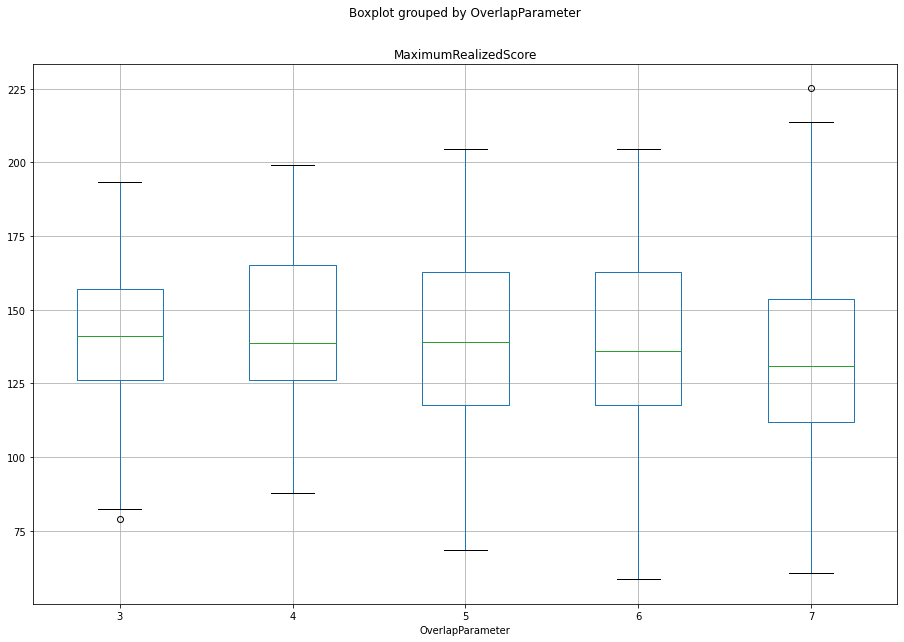

In [650]:
frame = pd.read_csv("./results.csv")
frame.groupby("OverlapParameter").mean()
frame.boxplot("MaximumRealizedScore", by="OverlapParameter", figsize=(15, 10))